In [1]:
import numpy as np
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_datareader
import datetime
import pandas_datareader.data as web
from scipy.stats import norm

In [2]:
tickers = ["CARR","NVDA","PAYC","MSCI","AMZN","MPWR","CDNS","DXCM","POOL","AVGO",
             "GOOG","MA","TDY","MSFT","COST","ODFL","AAPL","CPRT","NEM","CAMT","TSM","TER","NOW",
          "LLY"]

In [3]:
data = pd.DataFrame()

for t in tickers:
    try:
        data[t] = web.DataReader(t, data_source='yahoo', start='2016-1-1')['Adj Close']
    except:
        continue
        
data.to_csv("QUALITYUSGROWMay2022.csv")

In [4]:
returns = np.log(data / data.shift(1))
vols = returns.std() * 252 ** 0.5 *100
vols

CARR    44.556818
NVDA    50.387209
PAYC    49.998427
MSCI    37.818961
AMZN    35.050118
MPWR    49.412480
CDNS    38.218912
DXCM    45.788385
POOL    36.517334
AVGO    33.674491
GOOG    30.010331
MA      36.273444
TDY     31.648729
MSFT    29.224017
COST    21.804681
ODFL    33.311418
AAPL    32.773754
CPRT    34.138758
NEM     34.719991
CAMT    55.271573
TSM     37.402918
TER     48.855190
NOW     44.106110
LLY     33.094828
dtype: float64

In [5]:
annual_returns = returns.mean() * 252 * 100
annual_returns

CARR    55.140911
NVDA    59.410844
PAYC    19.769780
MSCI    27.035503
AMZN    10.009762
MPWR    52.365605
CDNS    46.283909
DXCM    28.590997
POOL    34.753800
AVGO    55.069390
GOOG    34.673106
MA      21.283449
TDY     28.803521
MSFT    32.036791
COST    26.775712
ODFL    45.519007
AAPL    44.785698
CPRT    22.517236
NEM     28.545565
CAMT    66.566479
TSM     36.564278
TER     39.620440
NOW     24.632590
LLY     38.522067
dtype: float64

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import pandas_datareader.data as web
import datetime
import math

class ValueAtRiskMonteCarlo:
    
    def __init__(self, S, mu, sigma, c, n, iterations):
        self.S = S
        self.mu = mu
        self.sigma = sigma
        self.c = c
        self.n = n
        self.iterations = iterations 

    def simulation(self):
        stock_data = np.zeros([self.iterations, 1])	
        rand = np.random.normal(0, 1, [1, self.iterations])

        #equation for the S(t) stock price
        stock_price = self.S*np.exp(self.n*(self.mu - 0.5*self.sigma**2)+self.sigma*np.sqrt(self.n)*rand)
        #we have to sort the stock prices to determine the percentile
        stock_price = np.sort(stock_price)

        #it depends on the confidence level: 95% -> 5 and 99% -> 1
        percentile = np.percentile(stock_price,(1-self.c)*100)

        return self.S-percentile

In [7]:

df = pd.DataFrame(columns = ['Ticker', 'Cov_mar','Market_var','Beta','Volatility%','Return%','Sharp Ratio','CAGR','MAXDD%','Value at Risk']) 
data = pd.DataFrame()
data['^IXIC'] = web.DataReader('^IXIC', data_source='yahoo', start='2015-1-1')['Adj Close'] 

for t in tickers:
    try:
        data[t] = web.DataReader(t, data_source='yahoo', start='2015-1-1')['Adj Close']  
    except:
        continue
    sec_returns = np.log( data / data.shift(1) )
    cov = sec_returns.cov()*252
    cov_with_market = cov[t][0]
 
      
    dr = data[t].pct_change()
    dcum = (1 + dr).cumprod()
    n = len(data)/252
    CAGR = ((dcum[-1])**(1/n) - 1)*100
      
 
    
    droll = dcum.cummax()
    ddw = droll - dcum
    ddmax = ddw/droll
    max_dd = (ddmax.max())*100
   
 

    market_var = sec_returns['^IXIC'].var() * 252

    returns = np.log(data[t] / data[t].shift(1))
    MSFT_beta = cov_with_market / market_var
    MSFT_er = returns.mean()*252
    Sharp = (MSFT_er - 0.05) / (sec_returns[t].std() * 252 ** 0.5)
   

    #returns = np.log(data[t] / data[t].shift(1))
    vols = returns.std() * 252 ** 0.5 *100
    annual_returns = returns.mean() * 252 * 100
    
    S = 100000    #this is the investment (stocks or whatever)
    c=0.95   #condifence level: this time it is 99%
    n = 730   #1 day 
    iterations = 100000 #number of paths in the Monte-Carlo simulation
    mu = np.mean(returns)
    sigma = np.mean(returns.std())

    model = ValueAtRiskMonteCarlo(S,mu,sigma,c,n,iterations)
    val = model.simulation()

 
    
 
    df = df.append(pd.Series([t,cov_with_market,market_var,MSFT_beta,vols,annual_returns,Sharp,CAGR,max_dd,val], index=df.columns ), ignore_index=True)
                                    
                        
  

In [8]:
df1 = df[(df['CAGR']>10 ) & (df['Return%']>10)]
df2 = df1.sort_values(by='Return%', ascending=False)
df2

,Ticker,Cov_mar,Market_var,Beta,Volatility%,Return%,Sharp Ratio,CAGR,MAXDD%,Value at Risk
0,CARR,0.036983,0.044878,0.824086,44.556822,55.140915,1.125325,17.357856,34.330652,-7532.834880
1,NVDA,0.070791,0.044878,1.577422,46.427415,49.965601,0.968514,64.770914,56.038443,15081.764499
2,PAYC,0.062091,0.044878,1.383565,45.488933,33.207949,0.620106,39.361346,51.142891,45496.603972
19,CAMT,0.050742,0.044878,1.130666,47.893027,32.796449,0.580386,38.789361,53.678470,51268.921667
5,MPWR,0.064716,0.044878,1.442055,38.991113,31.036741,0.667761,36.369734,37.226709,33543.678542
3,MSCI,0.046102,0.044878,1.027271,30.016883,30.669278,0.855161,35.869815,38.258538,7990.264662
6,CDNS,0.049573,0.044878,1.104618,30.925400,28.127077,0.747834,32.461087,32.116968,17403.778845
4,AMZN,0.047512,0.044878,1.058711,31.444127,27.464105,0.714413,31.586283,37.606965,20778.230208
9,AVGO,0.054102,0.044878,1.205542,35.498315,26.471771,0.604867,30.287664,48.299973,33691.682892
22,NOW,0.057649,0.044878,1.284585,39.063883,26.358556,0.546760,30.140322,47.616401,43113.698837


In [9]:
df2.to_csv("QULITYUSGROWTHMAYLAT2022.csv")

Text(0, 0.5, 'Expected Return')

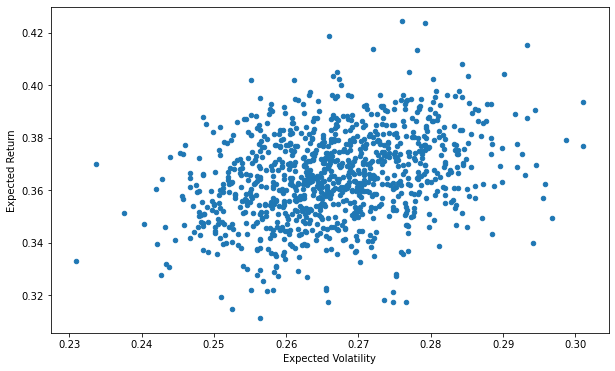

In [10]:
pf_data = pd.DataFrame()
for t in df1["Ticker"]:
    pf_data[t] = web.DataReader(t, data_source = 'yahoo', start = '2016-1-1')['Adj Close']

log_returns = np.log(pf_data / pf_data.shift(1))
num_assets = len(df1["Ticker"])
num_assets
weights = np.random.random(num_assets)
weights /= np.sum(weights)
weights
np.sum(weights * log_returns.mean()) * 252
np.dot(weights.T, np.dot(log_returns.cov() * 252, weights))
np.sqrt(np.dot(weights.T,np.dot(log_returns.cov() * 252, weights)))
pfolio_returns = []
pfolio_volatilities = []
wts = []
for x in range (1000):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    pfolio_returns.append(np.sum(weights * log_returns.mean()) * 252)
    pfolio_volatilities.append(np.sqrt(np.dot(weights.T,np.dot(log_returns.cov() * 252, weights))))
    wts.append(weights)
pfolio_returns = np.array(pfolio_returns)
pfolio_volatilities = np.array(pfolio_volatilities)
wts= np.array(wts)
#pfolio_returns, pfolio_volatilities
portfolios = pd.DataFrame({'Return': pfolio_returns, 'Volatility': pfolio_volatilities})
portfolios.plot(x='Volatility', y='Return', kind='scatter', figsize=(10, 6));
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')

In [11]:
df = pd.DataFrame(data=wts)
df.columns = df1["Ticker"]
df_col_merged = pd.concat([portfolios, df], axis=1)
dft = df_col_merged.loc[df_col_merged['Return'].argmax()]
dft*100

Return        42.422570
Volatility    27.601357
CARR           8.596134
NVDA           8.456395
PAYC           0.631339
MSCI           2.366304
AMZN           1.413890
MPWR           5.075782
CDNS           8.194330
DXCM           0.472800
POOL           3.750140
AVGO           6.532440
GOOG           8.802120
MA             0.548820
TDY            3.516149
MSFT           9.671504
COST           1.844921
ODFL           0.297685
AAPL           4.128923
CPRT           3.464686
NEM            6.040202
CAMT           7.537657
TSM            2.984247
TER            3.325228
NOW            1.154503
LLY            1.193801
Name: 478, dtype: float64

In [12]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import pandas_datareader.data as web
import datetime
import math

class ValueAtRiskMonteCarlo:
    
    def __init__(self, S, mu, sigma, c, n, iterations):
        self.S = S
        self.mu = mu
        self.sigma = sigma
        self.c = c
        self.n = n
        self.iterations = iterations 

    def simulation(self):
        stock_data = np.zeros([self.iterations, 1])	
        rand = np.random.normal(0, 1, [1, self.iterations])

        #equation for the S(t) stock price
        stock_price = self.S*np.exp(self.n*(self.mu - 0.5*self.sigma**2)+self.sigma*np.sqrt(self.n)*rand)
        #we have to sort the stock prices to determine the percentile
        stock_price = np.sort(stock_price)

        #it depends on the confidence level: 95% -> 5 and 99% -> 1
        percentile = np.percentile(stock_price,(1-self.c)*100)

        return self.S-percentile

if __name__ == "__main__":
    S = 100000    #this is the investment (stocks or whatever)
    c=0.95   #condifence level: this time it is 99%
    n = 730   #1 day 
    iterations = 100000 #number of paths in the Monte-Carlo simulation

    #historical data to approximate mean and standard deviation
    d = {}

    #download stock related data from Yahoo Finance
    for t in df1["Ticker"]:
        citi = web.DataReader(t,data_source='yahoo',start='2017-1-1')
           #we can use pct_change() to calculate daily returns
        citi['returns'] = citi['Adj Close'].pct_change()

    #we can assume daily returns to be normally sidtributed: mean and variance (standard deviation)
    #can describe the process
        mu = np.mean(citi['returns'])
        sigma = np.std(citi['returns'])

        model = ValueAtRiskMonteCarlo(S,mu,sigma,c,n,iterations)
        val = model.simulation()
        d[t] = val
        print("VALUE AT RSIK for {} is".format(t))
        print('Value at risk with Monte-Carlo simulation in INR: %0.2f' % val)
    print("The minimum value at risk for the portofolios are:")
    print(min(d.values()))

VALUE AT RSIK for CARR is
Value at risk with Monte-Carlo simulation in INR: -35609.70
VALUE AT RSIK for NVDA is
Value at risk with Monte-Carlo simulation in INR: 22540.16
VALUE AT RSIK for PAYC is
Value at risk with Monte-Carlo simulation in INR: 22237.68
VALUE AT RSIK for MSCI is
Value at risk with Monte-Carlo simulation in INR: -1646.71
VALUE AT RSIK for AMZN is
Value at risk with Monte-Carlo simulation in INR: 23654.61
VALUE AT RSIK for MPWR is
Value at risk with Monte-Carlo simulation in INR: 22173.63
VALUE AT RSIK for CDNS is
Value at risk with Monte-Carlo simulation in INR: -2821.06
VALUE AT RSIK for DXCM is
Value at risk with Monte-Carlo simulation in INR: 31620.96
VALUE AT RSIK for POOL is
Value at risk with Monte-Carlo simulation in INR: 8949.97
VALUE AT RSIK for AVGO is
Value at risk with Monte-Carlo simulation in INR: 21772.29
VALUE AT RSIK for GOOG is
Value at risk with Monte-Carlo simulation in INR: 16232.18
VALUE AT RSIK for MA is
Value at risk with Monte-Carlo simulation

In [13]:
for key,value in d.items():
    print(" The Value at risk per 1L invested in stock {} is {:0.2f}".format(key,value))

 The Value at risk per 1L invested in stock CARR is -35609.70
 The Value at risk per 1L invested in stock NVDA is 22540.16
 The Value at risk per 1L invested in stock PAYC is 22237.68
 The Value at risk per 1L invested in stock MSCI is -1646.71
 The Value at risk per 1L invested in stock AMZN is 23654.61
 The Value at risk per 1L invested in stock MPWR is 22173.63
 The Value at risk per 1L invested in stock CDNS is -2821.06
 The Value at risk per 1L invested in stock DXCM is 31620.96
 The Value at risk per 1L invested in stock POOL is 8949.97
 The Value at risk per 1L invested in stock AVGO is 21772.29
 The Value at risk per 1L invested in stock GOOG is 16232.18
 The Value at risk per 1L invested in stock MA is 17774.43
 The Value at risk per 1L invested in stock TDY is 16702.42
 The Value at risk per 1L invested in stock MSFT is -6626.85
 The Value at risk per 1L invested in stock COST is -8594.99
 The Value at risk per 1L invested in stock ODFL is -2490.66
 The Value at risk per 1L i

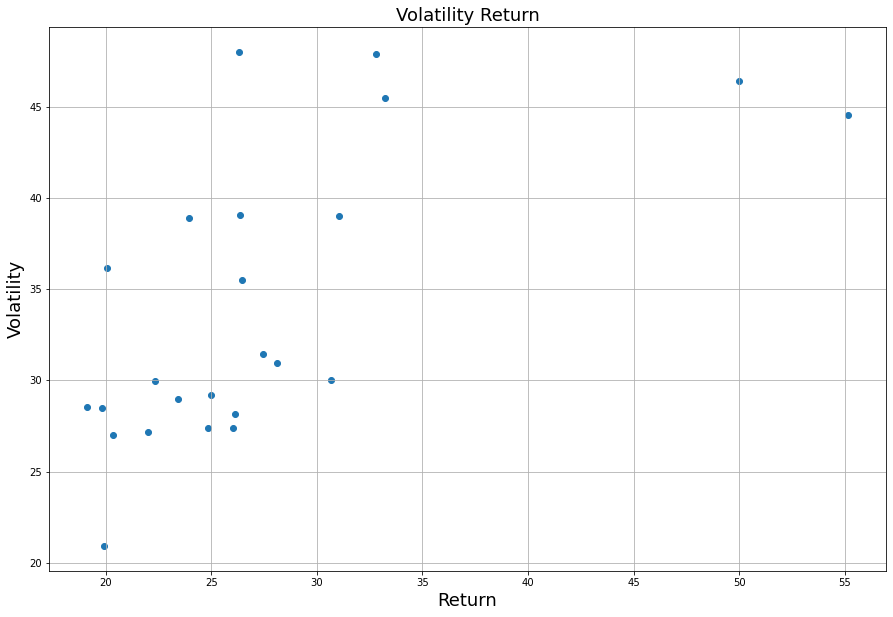

In [14]:
plt.figure(figsize=[15,10])
x= df2['Return%']
y = df2['Volatility%']

plt.grid(True)
plt.title('Volatility Return', fontsize=18, color='black')
plt.xlabel("Return",fontsize=18, color='black')
plt.ylabel("Volatility", fontsize=18, color='black') 
plt.scatter(x, y )
plt.show()

In [17]:
df2[(df2['Volatility%']<50 ) & (df2['Return%']>15)].sort_values(by='Volatility%',ascending=True)

,Ticker,Cov_mar,Market_var,Beta,Volatility%,Return%,Sharp Ratio,CAGR,MAXDD%,Value at Risk
14,COST,0.025620,0.044878,0.570884,20.913178,19.911135,0.713002,22.018651,22.017277,7032.163579
10,GOOG,0.045455,0.044878,1.012863,27.000887,20.340141,0.568135,22.542958,30.790138,23825.002335
23,LLY,0.024884,0.044878,0.554490,27.182394,22.016279,0.626004,24.613129,23.743009,20596.637770
13,MSFT,0.049716,0.044878,1.107819,27.399038,26.030047,0.767547,29.713731,28.039270,11292.471483
17,CPRT,0.038438,0.044878,0.856508,27.414619,24.863266,0.724550,28.209860,43.751197,14283.879635
8,POOL,0.034980,0.044878,0.779460,28.158587,26.128551,0.750341,29.841498,30.680970,13911.295706
11,MA,0.045225,0.044878,1.007735,28.497830,19.850239,0.521101,21.944409,40.997214,28931.101434
12,TDY,0.037137,0.044878,0.827509,28.528118,19.123982,0.495090,21.062462,48.946862,30413.058776
15,ODFL,0.037224,0.044878,0.829456,28.995645,23.422049,0.635338,26.376313,37.061458,22514.722704
16,AAPL,0.049874,0.044878,1.111331,29.224745,24.990146,0.684014,28.372548,38.515914,19872.936913


In [18]:
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# Read in price data
df = data

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.csv")  # saves to file
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('^IXIC', 0.0), ('CARR', 0.32465), ('NVDA', 0.19167), ('PAYC', 0.0), ('MSCI', 0.0), ('AMZN', 0.02998), ('MPWR', 0.0), ('CDNS', 0.0), ('DXCM', 0.0), ('POOL', 0.06024), ('AVGO', 0.0), ('GOOG', 0.0), ('MA', 0.0), ('TDY', 0.0), ('MSFT', 0.0), ('COST', 0.12093), ('ODFL', 0.0), ('AAPL', 0.0), ('CPRT', 0.0), ('NEM', 0.14615), ('CAMT', 0.0), ('TSM', 0.0), ('TER', 0.0), ('NOW', 0.0), ('LLY', 0.12638)])
Expected annual return: 48.1%
Annual volatility: 23.0%
Sharpe Ratio: 2.01


(0.4807845203144763, 0.22971558983860102, 2.0058913748005747)

In [24]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices


latest_prices = get_latest_prices(df)
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'CARR': 85, 'NVDA': 10, 'NEM': 20, 'LLY': 5, 'COST': 2, 'POOL': 2}
Funds remaining: $144.59


In [25]:
df2.sort_values(by='Volatility%', ascending=True)

,Ticker,Cov_mar,Market_var,Beta,Volatility%,Return%,Sharp Ratio,CAGR,MAXDD%,Value at Risk
14,COST,0.025620,0.044878,0.570884,20.913178,19.911135,0.713002,22.018651,22.017277,7032.163579
10,GOOG,0.045455,0.044878,1.012863,27.000887,20.340141,0.568135,22.542958,30.790138,23825.002335
23,LLY,0.024884,0.044878,0.554490,27.182394,22.016279,0.626004,24.613129,23.743009,20596.637770
13,MSFT,0.049716,0.044878,1.107819,27.399038,26.030047,0.767547,29.713731,28.039270,11292.471483
17,CPRT,0.038438,0.044878,0.856508,27.414619,24.863266,0.724550,28.209860,43.751197,14283.879635
8,POOL,0.034980,0.044878,0.779460,28.158587,26.128551,0.750341,29.841498,30.680970,13911.295706
11,MA,0.045225,0.044878,1.007735,28.497830,19.850239,0.521101,21.944409,40.997214,28931.101434
12,TDY,0.037137,0.044878,0.827509,28.528118,19.123982,0.495090,21.062462,48.946862,30413.058776
15,ODFL,0.037224,0.044878,0.829456,28.995645,23.422049,0.635338,26.376313,37.061458,22514.722704
16,AAPL,0.049874,0.044878,1.111331,29.224745,24.990146,0.684014,28.372548,38.515914,19872.936913


In [26]:
df2[(df2['Volatility%']<52 ) & (df2['Return%']>15) & (df2['Value at Risk'] <50000)].sort_values(by='Return%',ascending=False)

,Ticker,Cov_mar,Market_var,Beta,Volatility%,Return%,Sharp Ratio,CAGR,MAXDD%,Value at Risk
0,CARR,0.036983,0.044878,0.824086,44.556822,55.140915,1.125325,17.357856,34.330652,-7532.834880
1,NVDA,0.070791,0.044878,1.577422,46.427415,49.965601,0.968514,64.770914,56.038443,15081.764499
2,PAYC,0.062091,0.044878,1.383565,45.488933,33.207949,0.620106,39.361346,51.142891,45496.603972
5,MPWR,0.064716,0.044878,1.442055,38.991113,31.036741,0.667761,36.369734,37.226709,33543.678542
3,MSCI,0.046102,0.044878,1.027271,30.016883,30.669278,0.855161,35.869815,38.258538,7990.264662
6,CDNS,0.049573,0.044878,1.104618,30.925400,28.127077,0.747834,32.461087,32.116968,17403.778845
4,AMZN,0.047512,0.044878,1.058711,31.444127,27.464105,0.714413,31.586283,37.606965,20778.230208
9,AVGO,0.054102,0.044878,1.205542,35.498315,26.471771,0.604867,30.287664,48.299973,33691.682892
22,NOW,0.057649,0.044878,1.284585,39.063883,26.358556,0.546760,30.140322,47.616401,43113.698837
8,POOL,0.034980,0.044878,0.779460,28.158587,26.128551,0.750341,29.841498,30.680970,13911.295706


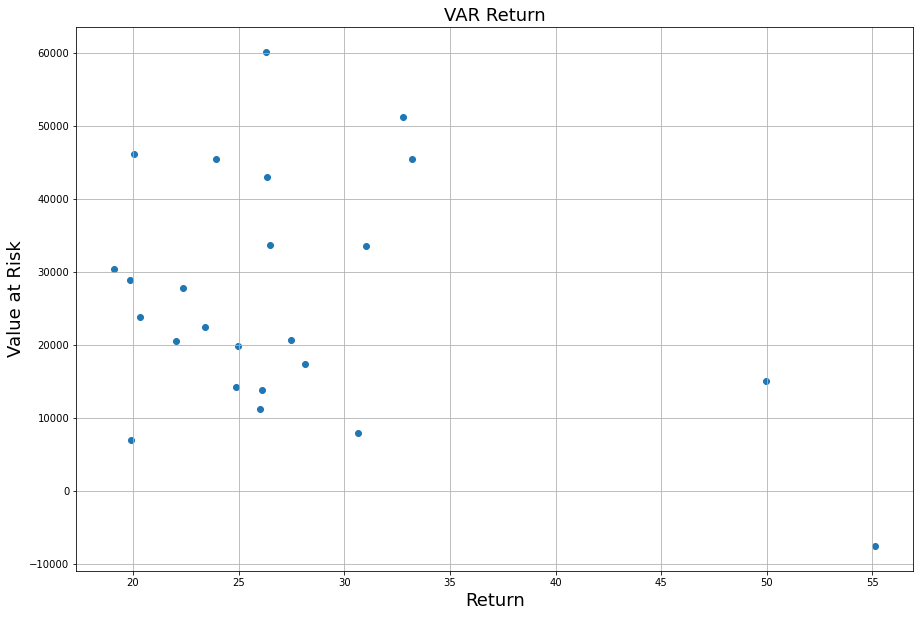

In [27]:
plt.figure(figsize=[15,10])
x= df2['Return%']
y = df2['Value at Risk']

plt.grid(True)
plt.title('VAR Return', fontsize=18, color='black')
plt.xlabel("Return",fontsize=18, color='black')
plt.ylabel("Value at Risk", fontsize=18, color='black') 
plt.scatter(x, y )
plt.show()

In [29]:
df2[(df2['Volatility%']<50 ) & (df2['Return%']>15) & (df2['Value at Risk'] >20000)].sort_values(by='Return%',ascending=False)

,Ticker,Cov_mar,Market_var,Beta,Volatility%,Return%,Sharp Ratio,CAGR,MAXDD%,Value at Risk
2,PAYC,0.062091,0.044878,1.383565,45.488933,33.207949,0.620106,39.361346,51.142891,45496.603972
19,CAMT,0.050742,0.044878,1.130666,47.893027,32.796449,0.580386,38.789361,53.678470,51268.921667
5,MPWR,0.064716,0.044878,1.442055,38.991113,31.036741,0.667761,36.369734,37.226709,33543.678542
4,AMZN,0.047512,0.044878,1.058711,31.444127,27.464105,0.714413,31.586283,37.606965,20778.230208
9,AVGO,0.054102,0.044878,1.205542,35.498315,26.471771,0.604867,30.287664,48.299973,33691.682892
22,NOW,0.057649,0.044878,1.284585,39.063883,26.358556,0.546760,30.140322,47.616401,43113.698837
7,DXCM,0.046309,0.044878,1.031899,48.010813,26.304756,0.443749,30.070363,56.373273,60194.553339
21,TER,0.057850,0.044878,1.289052,38.908575,23.938830,0.486752,27.030738,41.798654,45468.919141
15,ODFL,0.037224,0.044878,0.829456,28.995645,23.422049,0.635338,26.376313,37.061458,22514.722704
20,TSM,0.041941,0.044878,0.934571,29.971232,22.347060,0.578790,25.025784,35.831082,27847.784367
